In [2]:
import signal_aspect_detection
print(signal_aspect_detection.__version__)

0.0.1


rows 100 columns 50
10 45 20 75
(0, 20) (49, 20)


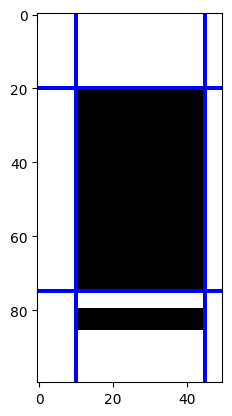

In [3]:
import numpy as np
import cv2
import skimage.io as io
import matplotlib.pyplot as plt

# height , width
img = np.zeros([100,50,3],dtype=np.uint8)
# x , y
cv2.rectangle(img, (0,0), (49,99) , (255,255,255,255), -1)
cv2.rectangle(img, (10,20), (45,75) , (0,0,0,255), -1)
cv2.rectangle(img, (10,80), (45,85) , (0,0,0,255), -1)

rows , columns = img.shape[0] , img.shape[1] 
print("rows",rows,"columns",columns)
(left,right,top,bottom) = signal_aspect_detection.crop_signal(img)
print(left,right,top,bottom)


print((0,top),(columns-1,top))
blue = (0,0,255)
cv2.line(img,(0,top),(columns-1,top),blue,thickness = 1)
cv2.line(img,(0,bottom),(columns-1,bottom),blue,thickness = 1)
cv2.line(img,(left,0),(left,rows-1),blue,thickness = 1)
cv2.line(img,(right,0),(right,rows-1),blue,thickness = 1)


plt.imshow(img)
plt.show()

In [4]:
from IPython.display import Markdown, display
from signal_aspect_detection import find_matches
from signal_aspect_detection import find_aspect
from signal_aspect_detection.signal_class import load_signal

kshauptsignal2 = load_signal('../models/signals/kshauptsignal2.json')
kshauptsignal3 = load_signal('../models/signals/kshauptsignal3.json')

ampelsignal = load_signal('../models/signals/ampel.json')

def md_table(signalLights,lights):
    table = "CircleRadius | Expansion | Flatness | Color | Position | Match\n"
    table += "--- | --- | --- | --- | --- | ---\n"
    for i in range(len(signalLights)):
        signalLight = signalLights[i]
        (x,y) = signalLight.getXY()
        table += "{:0.2f} | {:0.2f} | {:0.2f} | {} | {:0.2f},{:0.2f} | {}\n".format(
            signalLight.getCircleRadius(),
            signalLight.getExpansion(),
            signalLight.getFlatness(),
            signalLight.getColor(),
            x,y,
            lights[i])

    return table

def validate_matching(original,signal_definition):

    # resize image
    original_height , original_width , _ = original.shape
    width = 100 
    height = int(original_height * width / original_width)
    dim = (width, height)
  
    # resize image
    I = cv2.resize(original, dim, interpolation = cv2.INTER_AREA)
    
    
    rows , cols , _ = I.shape
    (left,right,top,bottom) = signal_aspect_detection.crop_signal(I)
    
    print("crop",(left,right,top,bottom))
    
    #fix crop if not found
    if left == -1: left = 0
    if right == -1: right = cols
    if top == -1: top = 0
    if bottom == -1: bottom = rows
        
    print("crop",(left,right,top,bottom))

    crop_color = (255,255,255) #blue (0,0,255)
    cv2.line(I,(0,top),(cols-1,top),crop_color,thickness = 1)
    cv2.line(I,(0,bottom),(cols-1,bottom),crop_color,thickness = 1)
    cv2.line(I,(left,0),(left,rows-1),crop_color,thickness = 1)
    cv2.line(I,(right,0),(right,rows-1),crop_color,thickness = 1)

    
    
    crop_img = I[top:bottom, left:right]

    img = signal_aspect_detection.filter_by_color2(crop_img)

    signalLights = signal_aspect_detection.find_lights(img,crop_img)
    print("signalLigths",len(signalLights))


    rows , cols , _ = crop_img.shape

    lights = find_matches(signalLights,cols,signal_definition)
    print("lights",len(lights))

    match = find_aspect(lights,signal_definition)  
    print("match",match)

    display(Markdown(md_table(signalLights,lights)))


    COLORS = {}
    COLORS["red"] = (255,0,0)
    COLORS["yellow"] = (255,255,0)
    COLORS["green"] = (0,255,0)
    COLORS["white"] = (255,255,255)
    COLORS["black"] = (0,0,0)
    COLORS["blue"] = (0,255,255)


    #nimg = np.zeros_like(crop_img)
    nimg = np.zeros([rows , cols,3],dtype=np.uint8)
    eimg = np.zeros([rows , cols,3],dtype=np.uint8)
    eimg.fill(200) # or img[:] = 255

    for i in range(len(signalLights)):
        signalLight = signalLights[i]
        color_class , _ = signalLight.getColor()[0]
        color = COLORS[color_class]
        cv2.ellipse(eimg, signalLight.getEllipse(), color , 2)

        if lights[i]:
            definition = lights[i][0][1]
            color_class = definition['color']
            color = COLORS[color_class]
            (x,y) = signalLight.getXY() 
            r = round(signalLight.getExpansion() / 2)
            cv2.circle(nimg, (round(x) , round(y)), r , color , -1)
            #print(x/cols,y/cols,r/cols,color_class)
        




    signal_image = np.zeros([100,50,3],dtype=np.uint8)
    if match:
        signal_definition.draw_signal_aspect(signal_image,(0,0), 50 ,match)


    plt.rcParams['figure.dpi'] = 100
    fig, axs = plt.subplots(nrows=1, ncols=6)
    axs[0].imshow(I)
    axs[1].imshow(crop_img) #cropped image
    axs[2].imshow(img) #filtered by color
    axs[3].imshow(eimg) #image with elipses
    axs[4].imshow(nimg) #matching paint matched colors
    axs[5].imshow(signal_image) #matched image
    plt.show()

    display(Markdown("# Matching"))
    if match:
        display(Markdown(">"+match))
    else:
        display(Markdown("No fiting match found"))


crop (14, 88, 9, 137)
crop (14, 88, 9, 137)
signalLigths 21
lights 21
match Hp 0+Zs 7


CircleRadius | Expansion | Flatness | Color | Position | Match
--- | --- | --- | --- | --- | ---
2.52 | 3.00 | 1.41 | [('black', 1.0)] | 64.00,125.50 | []
6.35 | 7.92 | 1.55 | [('yellow', 1.0)] | 36.19,116.78 | [('l83', {'x': 0.5, 'y': 1.56, 'radius': 0.08, 'color': 'yellow'}, 0.021106247560889253, 0.34052343078991476, 0.0)]
3.83 | 6.71 | 3.06 | [('black', 1.0)] | 14.21,109.94 | []
4.65 | 6.61 | 2.02 | [('black', 1.0)] | 30.95,109.70 | []
3.12 | 4.86 | 2.43 | [('black', 1.0)] | 17.82,105.39 | []
7.99 | 8.59 | 1.15 | [('yellow', 1.0)] | 55.63,87.90 | [('l82', {'x': 0.71, 'y': 1.25, 'radius': 0.08, 'color': 'yellow'}, 0.07494982079365661, 0.34052343078991476, 0.0)]
7.85 | 8.71 | 1.23 | [('yellow', 0.75), ('black', 0.25)] | 19.12,87.05 | [('l81', {'x': 0.29, 'y': 1.25, 'radius': 0.08, 'color': 'yellow'}, 0.08012231236635207, 0.34052343078991476, 0.25)]
0.15 | 0.15 | 1.00 | [('black', 1.0)] | 31.01,82.00 | []
2.52 | 3.00 | 1.41 | [('black', 1.0)] | 27.50,82.00 | []
0.15 | 0.15 | 1.00 | [('black', 1.0)] | 14.01,80.00 | []
2.52 | 3.00 | 1.41 | [('black', 1.0)] | 11.00,81.50 | []
2.52 | 3.00 | 1.41 | [('black', 1.0)] | 21.50,73.00 | []
2.52 | 3.00 | 1.41 | [('black', 1.0)] | 38.50,60.00 | []
2.52 | 3.00 | 1.41 | [('black', 1.0)] | 38.50,47.00 | []
2.52 | 3.00 | 1.41 | [('black', 1.0)] | 27.00,34.50 | []
17.81 | 17.91 | 1.01 | [('red', 0.8515625), ('yellow', 0.1484375)] | 39.22,35.57 | [('l1', {'x': 0.5, 'y': 0.5, 'radius': 0.14, 'color': 'red'}, 0.03571708733624868, 0.12223449193977871, 0.1484375)]
2.52 | 3.00 | 1.41 | [('black', 1.0)] | 29.00,12.50 | []
2.52 | 3.00 | 1.41 | [('black', 1.0)] | 39.50,8.00 | []
6.61 | 9.43 | 2.04 | [('black', 1.0)] | 64.84,7.80 | []
3.71 | 6.52 | 3.10 | [('green', 0.5882352941176471), ('black', 0.4117647058823529)] | 5.18,6.56 | []
38.17 | 41.12 | 1.16 | [('black', 1.0)] | -0.86,-14.30 | []


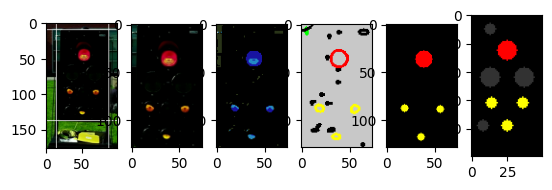

# Matching

>Hp 0+Zs 7

In [5]:
I = io.imread("../data/drohne-signals/traffic_light0029.png")
validate_matching(I,kshauptsignal2)

crop (0, 89, 8, 163)
crop (0, 89, 8, 163)
signalLigths 7
lights 7
match Ks 2+vBw


CircleRadius | Expansion | Flatness | Color | Position | Match
--- | --- | --- | --- | --- | ---
0.15 | 0.15 | 1.00 | [('black', 1.0)] | 38.01,131.00 | []
0.15 | 0.15 | 1.00 | [('black', 1.0)] | 16.01,130.00 | []
2.52 | 3.00 | 1.41 | [('black', 1.0)] | 26.50,88.00 | []
19.75 | 20.12 | 1.04 | [('yellow', 1.0)] | 64.83,75.11 | [('l3', {'x': 0.74, 'y': 0.88, 'radius': 0.14, 'color': 'yellow'}, 0.03785231704748477, 0.19103608464630173, 0.0)]
10.01 | 10.09 | 1.02 | [('white', 0.8536585365853658), ('black', 0.14634146341463414)] | 25.32,20.88 | [('l6', {'x': 0.26, 'y': 0.21, 'radius': 0.08, 'color': 'white'}, 0.034670826885910624, 0.3070199786016752, 0.14634146341463417)]
6.52 | 9.22 | 2.00 | [('black', 1.0)] | 77.50,9.50 | []
311.22 | 782.79 | 6.33 | [('black', 1.0)] | -52.30,-461.57 | []


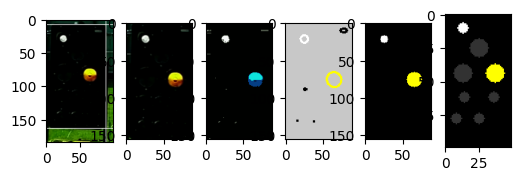

# Matching

>Ks 2+vBw

In [5]:
I = io.imread("../data/drohne-signals/traffic_light0032.png")
validate_matching(I,kshauptsignal2)

crop (14, 87, 2, 141)
crop (14, 87, 2, 141)
signalLigths 18
lights 18
match Ks 2+Vwh


CircleRadius | Expansion | Flatness | Color | Position | Match
--- | --- | --- | --- | --- | ---
0.15 | 0.15 | 1.00 | [('black', 1.0)] | 62.01,133.00 | []
6.25 | 8.47 | 1.84 | [('black', 0.5384615384615384), ('white', 0.46153846153846156)] | 14.79,124.38 | [('l7', {'x': 0.15, 'y': 1.56, 'radius': 0.08, 'color': 'white'}, 0.15314036304490786, 0.32870571156887424, 0.5384615384615384)]
0.00 | 0.45 | 32225135326920704.00 | [('black', 1.0)] | 9.75,120.00 | []
3.50 | 5.70 | 2.65 | [('black', 1.0)] | 28.59,90.20 | []
4.05 | 5.86 | 2.09 | [('black', 1.0)] | 9.55,89.34 | []
2.74 | 3.22 | 1.38 | [('black', 1.0)] | 18.15,78.00 | []
8.06 | 33.27 | 17.06 | [('black', 0.7529411764705882), ('red', 0.24705882352941178)] | 43.00,73.91 | []
0.15 | 0.15 | 1.00 | [('black', 1.0)] | 52.01,67.00 | []
4.82 | 6.59 | 1.87 | [('yellow', 1.0)] | 46.22,68.93 | []
4.01 | 4.57 | 1.30 | [('black', 1.0)] | 35.45,65.79 | []
8.95 | 12.84 | 2.06 | [('black', 0.7432432432432432), ('yellow', 0.25675675675675674)] | 58.21,68.71 | [('l3', {'x': 0.74, 'y': 0.88, 'radius': 0.14, 'color': 'yellow'}, 0.08392839899611142, 0.4625992908301007, 0.7432432432432432)]
7.67 | 29.47 | 14.75 | [('black', 1.0)] | 42.00,61.00 | []
0.85 | 1.99 | 5.55 | [('black', 1.0)] | 39.80,60.00 | []
9.09 | 10.14 | 1.24 | [('black', 1.0)] | 51.00,54.99 | []
5.54 | 9.71 | 3.08 | [('black', 1.0)] | 7.34,58.82 | []
3.89 | 5.78 | 2.21 | [('black', 1.0)] | 10.03,17.65 | []
3.70 | 3.99 | 1.16 | [('black', 1.0)] | 66.55,8.07 | []
18.98 | 19.36 | 1.04 | [('black', 1.0)] | -2.78,-1.58 | []


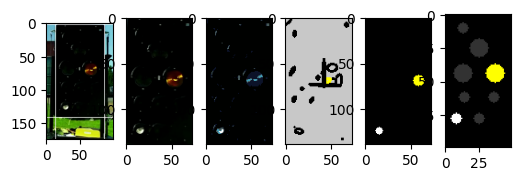

# Matching

>Ks 2+Vwh

In [6]:
I = io.imread("../data/drohne-signals/traffic_light0011.png")
validate_matching(I,kshauptsignal2)

crop (5, 95, 10, 181)
crop (5, 95, 10, 181)
signalLigths 9
lights 9
match Ks 2+vBw


CircleRadius | Expansion | Flatness | Color | Position | Match
--- | --- | --- | --- | --- | ---
14.01 | 14.03 | 1.00 | [('black', 1.0)] | 44.91,139.91 | []
14.01 | 14.03 | 1.00 | [('black', 1.0)] | 13.91,139.91 | []
14.01 | 14.03 | 1.00 | [('black', 1.0)] | 63.91,111.91 | []
14.01 | 14.03 | 1.00 | [('black', 1.0)] | 25.91,111.91 | []
26.29 | 26.31 | 1.00 | [('yellow', 0.9461400359066428), ('black', 0.05385996409335727)] | 66.87,78.87 | [('l3', {'x': 0.74, 'y': 0.88, 'radius': 0.14, 'color': 'yellow'}, 0.004737480993871116, 0.0271456143785476, 0.05385996409335725)]
26.29 | 26.31 | 1.00 | [('black', 1.0)] | 22.87,78.87 | []
26.29 | 26.31 | 1.00 | [('black', 1.0)] | 44.87,44.87 | []
14.01 | 14.03 | 1.00 | [('white', 0.8909090909090909), ('black', 0.10909090909090909)] | 22.91,18.91 | [('l6', {'x': 0.26, 'y': 0.21, 'radius': 0.08, 'color': 'white'}, 0.005418855740908014, 0.02446891283402327, 0.10909090909090913)]
0.12 | 0.12 | 1.00 | [('black', 1.0)] | 0.04,-0.03 | []


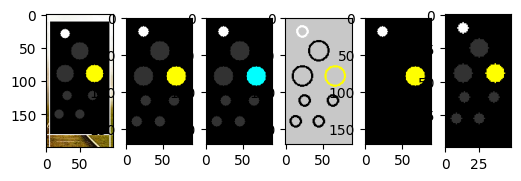

# Matching

>Ks 2+vBw

In [7]:
I = io.imread("../data/gen-signals/kshauptsignal2_Ks2_vBw.png")
validate_matching(I,kshauptsignal2)

crop (-1, -1, -1, -1)
crop (0, 100, 0, 212)
signalLigths 40
lights 40
match yellow + red


CircleRadius | Expansion | Flatness | Color | Position | Match
--- | --- | --- | --- | --- | ---
28.18 | 52.64 | 3.49 | [('black', 1.0)] | 103.12,217.24 | []
6.42 | 9.26 | 2.08 | [('black', 1.0)] | 81.46,198.49 | []
23.55 | 29.85 | 1.61 | [('black', 1.0)] | 108.62,205.63 | []
5.82 | 7.28 | 1.56 | [('black', 0.8125), ('white', 0.1875)] | 91.59,199.12 | []
3.99 | 10.14 | 6.45 | [('black', 1.0)] | 96.88,158.74 | []
4.54 | 7.95 | 3.07 | [('white', 0.72), ('red', 0.28)] | 58.93,151.42 | []
7.70 | 23.74 | 9.52 | [('black', 1.0)] | 91.06,155.43 | []
11.66 | 15.78 | 1.83 | [('red', 1.0)] | 40.06,148.39 | [('l3', {'x': 0.5, 'y': 1.5, 'radius': 0.17, 'color': 'red'}, 0.10069444083116909, 0.6547178687726608, 0.0)]
9.70 | 16.36 | 2.85 | [('red', 1.0)] | 67.72,143.82 | [('l3', {'x': 0.5, 'y': 1.5, 'radius': 0.17, 'color': 'red'}, 0.18765380716858301, 0.6547178687726608, 0.0)]
4.84 | 11.01 | 5.18 | [('white', 0.6551724137931034), ('red', 0.3448275862068966)] | 43.33,135.11 | [('l3', {'x': 0.5, 'y': 1.5, 'radius': 0.17, 'color': 'red'}, 0.16311662444873998, 0.9045953419892607, 0.6551724137931034)]
3.78 | 4.18 | 1.22 | [('white', 0.6), ('black', 0.4)] | 18.00,132.50 | []
9.73 | 94.35 | 94.10 | [('black', 1.0)] | 4.50,137.04 | []
8.68 | 22.98 | 7.01 | [('black', 1.0)] | 94.43,141.16 | []
3.62 | 3.85 | 1.13 | [('black', 1.0)] | 84.39,130.97 | []
4.91 | 8.93 | 3.31 | [('red', 1.0)] | 54.00,130.00 | []
15.73 | 22.38 | 2.03 | [('red', 0.7441860465116279), ('white', 0.2558139534883721)] | 49.93,129.73 | [('l3', {'x': 0.5, 'y': 1.5, 'radius': 0.17, 'color': 'red'}, 0.20265270187200587, 0.37811247244009794, 0.2558139534883721)]
4.62 | 7.02 | 2.31 | [('yellow', 1.0)] | 50.80,107.54 | []
13.54 | 19.95 | 2.17 | [('black', 0.6946107784431138), ('yellow', 0.30538922155688625)] | 44.90,109.96 | [('l2', {'x': 0.5, 'y': 1.0, 'radius': 0.17, 'color': 'yellow'}, 0.1118999012867753, 0.4608978427565479, 0.6946107784431137)]
20.54 | 24.31 | 1.40 | [('black', 0.5602240896358543), ('yellow', 0.43977591036414565)] | 57.96,103.21 | [('l2', {'x': 0.5, 'y': 1.0, 'radius': 0.17, 'color': 'yellow'}, 0.0858365698062634, 0.30253535066129833, 0.5602240896358543)]
10.90 | 16.45 | 2.28 | [('yellow', 1.0)] | 59.51,101.27 | [('l2', {'x': 0.5, 'y': 1.0, 'radius': 0.17, 'color': 'yellow'}, 0.09594430901704601, 0.6547178687726608, 0.0)]
57.68 | 176.57 | 9.37 | [('black', 1.0)] | 22.36,253.10 | []
9.26 | 14.07 | 2.31 | [('black', 0.5945945945945946), ('yellow', 0.40540540540540543)] | 38.77,96.19 | [('l2', {'x': 0.5, 'y': 1.0, 'radius': 0.17, 'color': 'yellow'}, 0.1186317113949577, 0.7707017627280341, 0.5945945945945945)]
13.88 | 18.56 | 1.79 | [('yellow', 1.0)] | 48.36,93.48 | [('l2', {'x': 0.5, 'y': 1.0, 'radius': 0.17, 'color': 'yellow'}, 0.067192811085213, 0.5524128238778983, 0.0)]
4.15 | 11.31 | 7.43 | [('black', 1.0)] | 65.77,91.26 | []
6.42 | 12.29 | 3.66 | [('black', 1.0)] | 54.30,86.22 | []
6.63 | 7.49 | 1.28 | [('black', 1.0)] | 42.35,81.56 | []
0.84 | 1.00 | 1.41 | [('black', 1.0)] | 49.00,67.50 | []
3.70 | 3.99 | 1.16 | [('black', 1.0)] | 85.55,66.07 | []
4.74 | 6.07 | 1.64 | [('black', 1.0)] | 57.70,66.48 | []
2.52 | 3.00 | 1.41 | [('black', 1.0)] | 69.50,59.00 | []
1.07 | 1.24 | 1.33 | [('black', 1.0)] | 57.50,57.00 | []
3.62 | 5.66 | 2.44 | [('black', 1.0)] | 54.12,59.18 | []
4.39 | 9.81 | 5.00 | [('white', 0.64), ('black', 0.36)] | 52.27,53.04 | []
5.51 | 7.87 | 2.04 | [('black', 1.0)] | 38.75,51.06 | []
5.24 | 7.58 | 2.09 | [('black', 1.0)] | 34.97,44.48 | []
27.14 | 32.59 | 1.44 | [('black', 0.7269789983844911), ('white', 0.2730210016155089)] | 51.21,55.45 | []
0.54 | 1.11 | 4.28 | [('black', 1.0)] | 98.00,36.50 | []
3.99 | 4.28 | 1.15 | [('black', 1.0)] | 86.26,30.75 | []
4.04 | 4.57 | 1.28 | [('black', 1.0)] | 14.34,29.83 | []
169.90 | 290.90 | 2.93 | [('black', 1.0)] | 46.80,123.94 | []


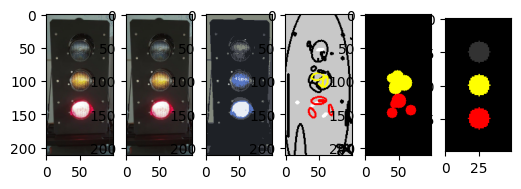

# Matching

>yellow + red

In [8]:
I = io.imread("../data/ks-signals/traffic_light0003.png")
validate_matching(I,ampelsignal)

crop (-1, -1, -1, -1)
crop (0, 100, 0, 200)
signalLigths 32
lights 32
match red


CircleRadius | Expansion | Flatness | Color | Position | Match
--- | --- | --- | --- | --- | ---
4.47 | 4.47 | 1.00 | [('black', 1.0)] | 90.00,182.00 | []
2.52 | 3.00 | 1.41 | [('red', 1.0)] | 71.00,165.50 | []
2.74 | 3.22 | 1.38 | [('black', 1.0)] | 28.15,164.00 | []
32.04 | 36.73 | 1.31 | [('red', 1.0)] | 49.89,160.44 | [('l3', {'x': 0.5, 'y': 1.5, 'radius': 0.17, 'color': 'red'}, 0.10438524118268935, 0.049647167450064186, 0.0)]
29.42 | 32.53 | 1.22 | [('black', 1.0)] | 24.32,135.65 | []
4.80 | 5.51 | 1.32 | [('black', 1.0)] | 92.35,144.44 | []
4.47 | 4.47 | 1.00 | [('black', 1.0)] | 9.00,145.00 | []
0.00 | 0.71 | 89166708602462368.00 | [('black', 1.0)] | 36.25,116.75 | []
21.94 | 29.93 | 1.86 | [('black', 1.0)] | 57.17,112.77 | []
12.21 | 13.58 | 1.24 | [('black', 1.0)] | 60.81,112.18 | []
6.56 | 9.22 | 1.97 | [('black', 1.0)] | 47.07,105.96 | []
4.92 | 5.42 | 1.21 | [('black', 1.0)] | 94.05,104.83 | []
4.83 | 5.02 | 1.08 | [('black', 1.0)] | 7.89,104.61 | []
12.78 | 20.21 | 2.50 | [('black', 1.0)] | 66.13,96.87 | []
29.20 | 30.82 | 1.11 | [('black', 1.0)] | 44.43,101.85 | []
34.19 | 40.52 | 1.40 | [('black', 1.0)] | 47.95,104.10 | []
1.89 | 7.15 | 14.28 | [('black', 1.0)] | 41.92,86.79 | []
16.45 | 25.14 | 2.34 | [('black', 1.0)] | 50.46,87.38 | []
0.15 | 0.15 | 1.00 | [('black', 1.0)] | 94.01,59.00 | []
5.24 | 5.56 | 1.13 | [('black', 1.0)] | 7.22,61.88 | []
42.40 | 91.99 | 4.71 | [('black', 1.0)] | 19.35,62.26 | []
6.22 | 21.34 | 11.75 | [('black', 1.0)] | 70.75,58.40 | []
19.68 | 24.59 | 1.56 | [('black', 1.0)] | 56.35,58.62 | []
4.36 | 13.86 | 10.12 | [('black', 1.0)] | 46.12,49.42 | []
8.53 | 17.85 | 4.38 | [('black', 1.0)] | 34.24,52.59 | []
2.55 | 5.83 | 5.21 | [('black', 1.0)] | 75.76,40.36 | []
10.71 | 22.67 | 4.48 | [('black', 1.0)] | 31.43,40.76 | []
2.81 | 3.58 | 1.63 | [('white', 0.7777777777777778), ('black', 0.2222222222222222)] | 33.77,27.08 | []
352.57 | 755.53 | 4.59 | [('black', 1.0)] | 233.76,353.53 | []
6.75 | 14.61 | 4.69 | [('black', 0.7346938775510204), ('white', 0.2653061224489796)] | 44.24,24.76 | []
8.83 | 13.92 | 2.49 | [('black', 1.0)] | 11.27,21.03 | []
29.79 | 31.25 | 1.10 | [('black', 1.0)] | -1.26,-9.45 | []


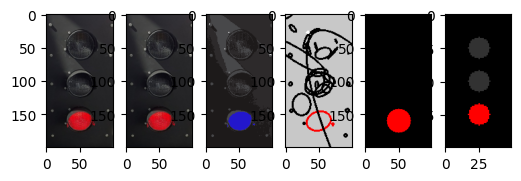

# Matching

>red

In [9]:
I = io.imread("../data/ks-signals/traffic_light0007.png")
validate_matching(I,ampelsignal)

crop (-1, -1, -1, -1)
crop (0, 100, 0, 183)
signalLigths 20
lights 20
match yellow


CircleRadius | Expansion | Flatness | Color | Position | Match
--- | --- | --- | --- | --- | ---
2.74 | 3.22 | 1.38 | [('black', 1.0)] | 12.85,180.00 | []
4.18 | 5.65 | 1.83 | [('black', 1.0)] | 91.26,178.63 | []
59.46 | 74.55 | 1.57 | [('black', 1.0)] | 62.86,173.96 | []
4.04 | 4.57 | 1.28 | [('black', 1.0)] | 11.66,144.17 | []
4.25 | 5.53 | 1.69 | [('black', 1.0)] | 10.83,105.66 | []
4.18 | 5.65 | 1.83 | [('black', 1.0)] | 92.63,103.74 | []
0.12 | 0.19 | 2.42 | [('black', 1.0)] | 67.00,92.00 | []
34.72 | 36.80 | 1.12 | [('yellow', 0.8358662613981763), ('red', 0.1641337386018237)] | 50.92,104.96 | [('l2', {'x': 0.5, 'y': 1.0, 'radius': 0.17, 'color': 'yellow'}, 0.050442156604123135, 0.049647167450064186, 0.16413373860182368)]
4.04 | 4.18 | 1.07 | [('white', 0.5384615384615384), ('black', 0.46153846153846156)] | 34.97,88.96 | []
21.67 | 28.58 | 1.74 | [('yellow', 0.6666666666666666), ('black', 0.3333333333333333)] | 48.10,94.32 | [('l2', {'x': 0.5, 'y': 1.0, 'radius': 0.17, 'color': 'yellow'}, 0.059947317414455845, 0.1686417714000718, 0.33333333333333337)]
5.18 | 6.63 | 1.64 | [('black', 1.0)] | 9.88,64.69 | []
9.26 | 14.94 | 2.60 | [('black', 1.0)] | 58.89,54.45 | []
7.50 | 11.86 | 2.50 | [('black', 0.8571428571428571), ('white', 0.14285714285714285)] | 29.39,52.28 | []
13.07 | 37.50 | 8.23 | [('black', 0.9101796407185628), ('white', 0.08982035928143713)] | 85.34,54.12 | []
2.57 | 3.05 | 1.41 | [('black', 1.0)] | 29.05,43.34 | []
3.95 | 5.55 | 1.97 | [('black', 0.5555555555555556), ('white', 0.4444444444444444)] | 34.31,32.13 | []
10.61 | 18.30 | 2.98 | [('black', 1.0)] | 39.58,33.35 | []
4.36 | 5.18 | 1.41 | [('black', 1.0)] | 94.87,20.62 | []
8.45 | 16.41 | 3.77 | [('black', 1.0)] | 6.50,18.00 | []
127.05 | 154.67 | 1.48 | [('black', 1.0)] | -4.00,0.30 | []


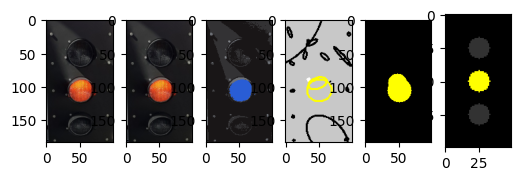

# Matching

>yellow

In [10]:
I = io.imread("../data/ks-signals/traffic_light0008.png")
validate_matching(I,ampelsignal)

crop (-1, -1, -1, -1)
crop (0, 100, 0, 171)
signalLigths 21
lights 21
match green


CircleRadius | Expansion | Flatness | Color | Position | Match
--- | --- | --- | --- | --- | ---
2.92 | 6.02 | 4.24 | [('white', 1.0)] | 97.39,166.88 | []
4.54 | 7.80 | 2.96 | [('black', 1.0)] | 45.49,155.31 | []
2.52 | 3.00 | 1.41 | [('black', 1.0)] | 34.50,141.00 | []
3.59 | 5.08 | 2.00 | [('black', 1.0)] | 62.00,111.09 | []
5.11 | 6.50 | 1.62 | [('black', 1.0)] | 53.01,109.07 | []
4.22 | 4.83 | 1.31 | [('black', 1.0)] | 10.14,106.09 | []
3.70 | 4.96 | 1.80 | [('black', 1.0)] | 35.92,102.56 | []
10.35 | 99.71 | 92.90 | [('black', 1.0)] | 97.48,121.33 | []
21.65 | 28.49 | 1.73 | [('black', 1.0)] | 49.54,96.18 | []
7.15 | 14.13 | 3.90 | [('blue', 0.5423728813559322), ('green', 0.4576271186440678)] | 59.06,59.54 | [('l1', {'x': 0.5, 'y': 0.5, 'radius': 0.17, 'color': 'green'}, 0.1315550030623123, 0.7707017627280341, 0.5423728813559322)]
4.41 | 5.32 | 1.46 | [('black', 1.0)] | 9.45,66.90 | []
4.37 | 5.20 | 1.41 | [('white', 0.6666666666666666), ('black', 0.3333333333333333)] | 90.50,66.50 | []
4.56 | 7.84 | 2.96 | [('black', 0.64), ('green', 0.36)] | 71.45,57.25 | []
2.81 | 3.58 | 1.63 | [('black', 1.0)] | 28.08,46.77 | []
4.29 | 8.06 | 3.54 | [('green', 0.7727272727272727), ('white', 0.22727272727272727)] | 55.22,47.17 | []
2.44 | 7.53 | 9.52 | [('black', 1.0)] | 32.63,41.68 | []
33.54 | 33.91 | 1.02 | [('green', 0.5190010857763301), ('blue', 0.4809989142236699)] | 49.91,53.42 | [('l1', {'x': 0.5, 'y': 0.5, 'radius': 0.17, 'color': 'green'}, 0.03421894231223417, 0.0, 0.4809989142236699)]
6.19 | 12.96 | 4.38 | [('black', 0.6904761904761905), ('white', 0.30952380952380953)] | 44.11,33.68 | []
3.93 | 4.83 | 1.51 | [('white', 0.7692307692307693), ('black', 0.23076923076923078)] | 91.74,24.95 | []
5.33 | 7.10 | 1.78 | [('black', 0.5666666666666667), ('white', 0.43333333333333335)] | 8.51,24.93 | []
65.32 | 67.82 | 1.08 | [('black', 1.0)] | 0.59,-0.32 | []


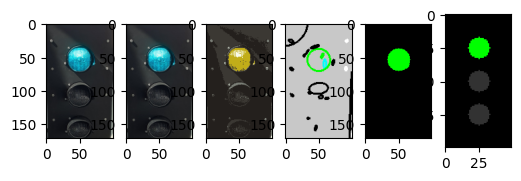

# Matching

>green

In [11]:
I = io.imread("../data/ks-signals/traffic_light0002.png")
validate_matching(I,ampelsignal)

crop (-1, -1, -1, -1)
crop (0, 100, 0, 212)
signalLigths 20
lights 20
match red


CircleRadius | Expansion | Flatness | Color | Position | Match
--- | --- | --- | --- | --- | ---
15.35 | 34.19 | 4.96 | [('red', 1.0)] | 107.11,209.65 | []
5.04 | 9.81 | 3.79 | [('red', 1.0)] | 92.49,201.90 | []
9.76 | 16.62 | 2.90 | [('black', 1.0)] | 5.78,201.89 | []
9.82 | 13.80 | 1.98 | [('red', 1.0)] | 26.47,202.56 | []
9.47 | 16.61 | 3.08 | [('red', 1.0)] | 16.50,191.75 | []
3.80 | 5.43 | 2.04 | [('red', 1.0)] | 9.77,182.00 | []
5.36 | 9.19 | 2.94 | [('black', 1.0)] | 3.45,170.80 | []
8.80 | 10.42 | 1.40 | [('red', 1.0)] | 92.46,163.23 | []
73.80 | 87.78 | 1.41 | [('red', 0.7751831501831502), ('white', 0.22481684981684982)] | 57.49,144.05 | [('l3', {'x': 0.5, 'y': 1.5, 'radius': 0.17, 'color': 'red'}, 0.09561841943626032, 0.8260075102158269, 0.2248168498168498)]
4.03 | 7.17 | 3.16 | [('red', 1.0)] | 75.73,130.21 | []
36.88 | 39.53 | 1.15 | [('white', 0.7864864864864864), ('red', 0.21351351351351353)] | 54.40,137.15 | [('l3', {'x': 0.5, 'y': 1.5, 'radius': 0.17, 'color': 'red'}, 0.1358329625998603, 0.14116214857141451, 0.7864864864864864)]
23.73 | 23.92 | 1.02 | [('red', 1.0)] | 16.57,182.41 | []
11.80 | 33.04 | 7.84 | [('red', 1.0)] | 81.82,109.27 | []
2.52 | 3.00 | 1.41 | [('red', 1.0)] | 15.00,97.50 | []
112.97 | 155.95 | 1.91 | [('red', 1.0)] | 40.44,173.03 | []
2.52 | 3.00 | 1.41 | [('red', 1.0)] | 12.00,63.50 | []
3.31 | 4.44 | 1.80 | [('red', 1.0)] | 83.71,58.00 | []
25.09 | 45.90 | 3.35 | [('black', 1.0)] | 21.12,72.19 | []
119.00 | 178.56 | 2.25 | [('black', 1.0)] | 68.24,130.61 | []
206.69 | 422.83 | 4.18 | [('black', 1.0)] | 50.89,161.11 | []


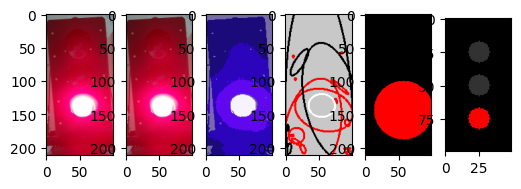

# Matching

>red

In [12]:
I = io.imread("../data/ks-signals/traffic_light0006.png")
validate_matching(I,ampelsignal)

crop (-1, -1, -1, -1)
crop (0, 100, 0, 200)
signalLigths 18
lights 18
match Kennlicht


CircleRadius | Expansion | Flatness | Color | Position | Match
--- | --- | --- | --- | --- | ---
2.52 | 3.00 | 1.41 | [('black', 1.0)] | 90.00,198.50 | []
19.49 | 69.29 | 12.64 | [('black', 1.0)] | 43.15,197.64 | []
2.52 | 3.00 | 1.41 | [('blue', 1.0)] | 98.50,188.00 | []
5.16 | 5.59 | 1.17 | [('black', 1.0)] | 85.48,184.62 | []
17.41 | 19.21 | 1.22 | [('red', 1.0)] | 25.72,166.20 | []
27.32 | 33.86 | 1.54 | [('black', 1.0)] | 83.49,140.70 | []
62.26 | 89.12 | 2.05 | [('black', 1.0)] | 69.05,164.16 | []
15.71 | 104.29 | 44.09 | [('blue', 1.0)] | 97.35,129.22 | []
28.40 | 47.13 | 2.75 | [('black', 1.0)] | 86.61,104.51 | []
9.85 | 17.37 | 3.11 | [('black', 1.0)] | 48.69,95.82 | []
26.56 | 67.28 | 6.41 | [('black', 1.0)] | 87.57,90.64 | []
79.14 | 139.74 | 3.12 | [('black', 1.0)] | 22.03,132.15 | []
17.37 | 19.36 | 1.24 | [('black', 0.6313725490196078), ('green', 0.3686274509803922)] | 28.49,36.15 | []
6.30 | 7.02 | 1.24 | [('black', 0.6097560975609756), ('white', 0.3902439024390244)] | 91.13,23.07 | []
8.13 | 8.60 | 1.12 | [('white', 0.5161290322580645), ('black', 0.4838709677419355)] | 11.26,22.90 | [('l6', {'x': 0.26, 'y': 0.21, 'radius': 0.08, 'color': 'white'}, 0.14858854545010525, 0.6020599913279624, 0.4838709677419355)]
7.17 | 7.67 | 1.15 | [('black', 0.6444444444444445), ('white', 0.35555555555555557)] | 64.36,21.14 | []
72.89 | 86.29 | 1.40 | [('black', 1.0)] | 48.95,48.24 | []
188.54 | 262.93 | 1.94 | [('black', 1.0)] | 47.47,93.13 | []


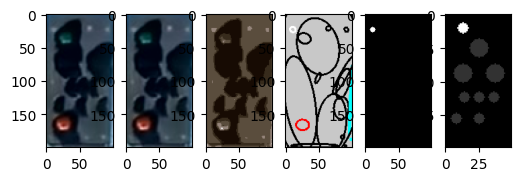

# Matching

>Kennlicht

In [16]:
I = io.imread("../data/histogram_test.png")
validate_matching(I,kshauptsignal3)

crop (-1, -1, -1, -1)
crop (0, 100, 0, 170)
signalLigths 23
lights 23
match None


CircleRadius | Expansion | Flatness | Color | Position | Match
--- | --- | --- | --- | --- | ---
23.28 | 57.56 | 6.11 | [('black', 1.0)] | 80.28,166.55 | []
0.10 | 0.18 | 3.31 | [('black', 1.0)] | 47.50,164.00 | []
16.93 | 36.54 | 4.65 | [('white', 0.706766917293233), ('black', 0.2932330827067669)] | 27.14,165.04 | [('l7', {'x': 0.15, 'y': 1.56, 'radius': 0.08, 'color': 'white'}, 0.15141661815314303, 0.704365036222725, 0.29323308270676696)]
24.04 | 80.29 | 11.15 | [('black', 1.0)] | 48.44,156.13 | []
8.36 | 10.54 | 1.59 | [('white', 0.59375), ('black', 0.40625)] | 55.01,134.76 | [('l9', {'x': 0.5, 'y': 1.25, 'radius': 0.08, 'color': 'white'}, 0.10974654572104524, 0.4082399653118495, 0.40625)]
5.85 | 7.59 | 1.68 | [('black', 1.0)] | 14.56,124.50 | []
10.34 | 45.63 | 19.47 | [('black', 1.0)] | 39.42,129.70 | []
224.65 | 606.37 | 7.29 | [('black', 1.0)] | 299.49,67.43 | []
89.04 | 130.44 | 2.15 | [('black', 1.0)] | 4.28,118.21 | []
29.33 | 31.24 | 1.13 | [('white', 0.5488372093023256), ('black', 0.4511627906976744)] | 101.97,163.23 | []
5.56 | 7.51 | 1.82 | [('black', 1.0)] | 73.81,89.82 | []
14.58 | 27.40 | 3.53 | [('black', 1.0)] | 20.48,95.08 | []
15.20 | 26.78 | 3.10 | [('black', 1.0)] | 78.88,96.05 | []
8.51 | 18.73 | 4.85 | [('black', 1.0)] | 88.96,76.78 | []
4.31 | 4.85 | 1.27 | [('green', 1.0)] | 35.48,70.18 | []
21.51 | 100.54 | 21.84 | [('black', 1.0)] | 7.32,107.15 | []
13.21 | 17.46 | 1.75 | [('green', 0.5827814569536424), ('black', 0.41721854304635764)] | 45.84,71.36 | []
5.62 | 18.05 | 10.31 | [('black', 1.0)] | 62.05,55.62 | []
11.12 | 40.28 | 13.11 | [('black', 1.0)] | 80.81,55.90 | []
2.52 | 3.00 | 1.41 | [('black', 1.0)] | 58.50,45.00 | []
50.75 | 79.38 | 2.45 | [('black', 1.0)] | 53.26,30.69 | []
8.37 | 14.07 | 2.83 | [('black', 1.0)] | 47.87,8.24 | []
121.13 | 129.28 | 1.14 | [('black', 1.0)] | -23.89,-28.97 | []


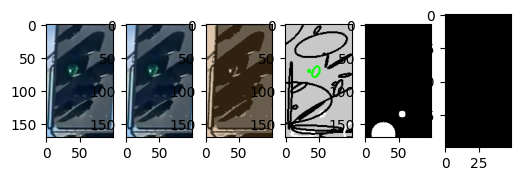

# Matching

No fiting match found

In [17]:
I = io.imread("../data/35_original.png")
validate_matching(I,kshauptsignal3)

crop (-1, -1, -1, -1)
crop (0, 100, 0, 180)
signalLigths 29
lights 29
match None


/root/dev/src/signal_aspect_detection/light_class.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  return np.max([xax,yax]) / np.min([xax,yax])


CircleRadius | Expansion | Flatness | Color | Position | Match
--- | --- | --- | --- | --- | ---
0.00 | 1.00 | inf | [('black', 1.0)] | 45.83,178.50 | []
3.66 | 7.51 | 4.20 | [('black', 1.0)] | 47.72,175.02 | []
5.64 | 6.81 | 1.46 | [('black', 1.0)] | 49.18,173.75 | []
0.15 | 0.15 | 1.00 | [('black', 1.0)] | 43.99,172.00 | []
58.00 | 163.15 | 7.91 | [('black', 1.0)] | -19.79,186.70 | []
6.13 | 7.80 | 1.62 | [('black', 0.9459459459459459), ('white', 0.05405405405405406)] | 92.00,161.00 | []
5.35 | 9.00 | 2.83 | [('black', 0.7241379310344828), ('white', 0.27586206896551724)] | 95.50,158.00 | []
0.15 | 0.15 | 1.00 | [('black', 1.0)] | 92.01,150.00 | []
2.06 | 2.21 | 1.15 | [('black', 1.0)] | 91.82,142.63 | []
2.52 | 3.00 | 1.41 | [('black', 1.0)] | 93.00,136.50 | []
5.21 | 8.25 | 2.51 | [('black', 0.7333333333333333), ('white', 0.26666666666666666)] | 95.75,133.00 | []
26.56 | 26.67 | 1.01 | [('yellow', 1.0)] | 74.32,142.02 | [('l82', {'x': 0.71, 'y': 1.25, 'radius': 0.08, 'color': 'yellow'}, 0.1734553562783067, 0.42170673062978636, 0.0)]
26.59 | 26.95 | 1.03 | [('yellow', 1.0)] | 24.20,142.20 | [('l81', {'x': 0.29, 'y': 1.25, 'radius': 0.08, 'color': 'yellow'}, 0.1785281621275248, 0.42170673062978636, 0.0)]
4.57 | 8.37 | 3.35 | [('black', 0.9166666666666666), ('white', 0.08333333333333333)] | 94.72,127.77 | []
8.07 | 9.96 | 1.52 | [('black', 1.0)] | 96.09,99.82 | []
18.22 | 36.70 | 4.06 | [('black', 1.0)] | 95.43,104.78 | []
35.78 | 76.86 | 4.62 | [('black', 0.6101083032490975), ('white', 0.3898916967509025)] | 99.33,57.04 | []
0.77 | 0.89 | 1.32 | [('white', 1.0)] | 93.80,76.21 | []
15.04 | 21.32 | 2.01 | [('white', 0.7486033519553073), ('black', 0.25139664804469275)] | 95.53,71.25 | []
2.52 | 3.00 | 1.41 | [('black', 1.0)] | 92.00,46.50 | []
2.52 | 3.00 | 1.41 | [('black', 1.0)] | 92.50,33.00 | []
12.48 | 19.56 | 2.46 | [('black', 1.0)] | 46.65,27.30 | []
13.05 | 41.69 | 10.20 | [('black', 1.0)] | 4.71,30.32 | []
2.52 | 3.00 | 1.41 | [('black', 1.0)] | 49.00,8.50 | []
2.52 | 3.00 | 1.41 | [('black', 1.0)] | 86.50,7.00 | []
3.97 | 5.53 | 1.94 | [('black', 1.0)] | 9.97,7.01 | []
7.41 | 12.85 | 3.01 | [('black', 1.0)] | 91.19,10.24 | []
3.96 | 5.77 | 2.13 | [('black', 1.0)] | 94.82,5.89 | []
145.09 | 211.80 | 2.13 | [('black', 1.0)] | 46.05,77.96 | []


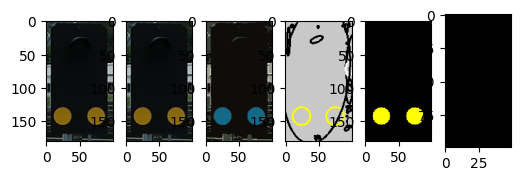

# Matching

No fiting match found

In [18]:
I = io.imread("../data/scheibenberg.png")
validate_matching(I,kshauptsignal3)

crop (-1, -1, 133, 167)
crop (0, 100, 133, 167)
signalLigths 1
lights 1
match off


CircleRadius | Expansion | Flatness | Color | Position | Match
--- | --- | --- | --- | --- | ---
120.11 | 155.46 | 1.68 | [('black', 1.0)] | 50.07,1.25 | []


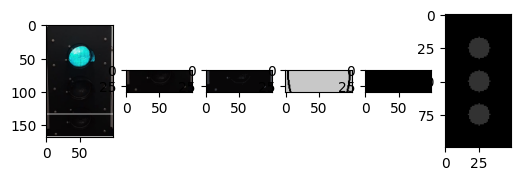

# Matching

>off

In [24]:
#I = io.imread("../data/01_original.png")
I = io.imread("../data/img_000008.jpg")
validate_matching(I,ampelsignal)